# Evaluate the impact of contrasive samples (`loss_c`) in the quality of partitioned latent space
Jan 18, 2021
- via. embedding of content codes + color-coding by (1) content-labels and (2) style-labels
- also, repeat the same visualization for the embedding of style codes

## Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [4]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [6]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [7]:
# Data transforms
from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler
from src.data.transforms.functional import unnormalize

# Utils
from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info, get_next_version_path
from collections import OrderedDict

In [8]:
# DataModules
from src.data.datamodules import MNISTDataModule, MNISTMDataModule, MonoMNISTDataModule
from src.data.datamodules import MultiMonoMNISTDataModule

# plModules
from src.models.plmodules.vanilla_vae import VanillaVAE
from src.models.plmodules.iwae import IWAE
from src.models.plmodules.bilatent_vae import BiVAE

# Evaluations
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.utilities.cloud_io import load as pl_load
from src.evaluator.qualitative import save_content_transfers, save_style_transfers, run_both_transfers

## Start experiment 
Given a maptile, predict its style as one of OSM, CartoVoyager

In [9]:
from src.models.plmodules.vanilla_vae import VanillaVAE
from src.models.plmodules.bilatent_vae import BiVAE
from src.models.plmodules.three_fcs import ThreeFCs


# Evaluation NB to load and evaluate a trained model
Steps:
- Define the architecutre of the model to load
- Load the model at `ckpt_path`
- Run the following evaluations

Evaluations:
1. Evaluation of the generative model
- Quantitative: `best_score`, which is the lowest loss computed as an average loss per datapt in the validation set. The loss is the estimate of the negative maginal log-likelihood of the observed data based on the trained model

- Qualitative: 
  - Reconstruction of datapts from train/val datasets
    - This evaluates how well the generative model (encoder-decoder) preserves the information needed to reconstruct the input data after having learned/trained/optimized jointly with/in the presence of its adversary, the style-classifier/discriminator

2. Evaluation of the discriminator
- How well does it discriminate? 
  - based on a style code: the model should predict the style label of the input datapt well
    - Compute the `loss_s` over the train/val datasets (as an expectation, ie. loss value per datapt/image)
  - based on a content code: the model should say "I'm not sure, aka. all style labels seem equally probable"
    - Compute the `loss_s` over the train/val datasets (as an expectation, ie. loss value per datapt/image)
  - Q: what is the range of the `loss_s` or `loss_c` for a good style-classifer?
   

## Define data for evaluation

In [10]:
# Init Multisource-Monochrome MNIST datamodule
mono_dir = ROOT/'data/Mono-MNIST'
colors = ['red', 'green', 'blue']
seed = 123
in_shape = (3,32,32)
batch_size = 128

# Create a multi-source dataset
dm = MultiMonoMNISTDataModule(
    data_root=mono_dir,
    colors=colors,
    seed=seed,
    in_shape=in_shape,
    batch_size=batch_size,
    shuffle=True,
)
dm.setup('fit')


## Define model architecture


In [11]:
def get_model_class(model_name: str) -> object:
    model_name = model_name.lower()
    return {
        "three_fcs": ThreeFCs,
        "vae": VanillaVAE,
        "iwae": IWAE,
        "bivae": BiVAE,

    }[model_name]

In [13]:
# Init plModule
latent_dim = 20
hidden_dims = [32,64,128,256]#,512]
lr = 3e-3
act_fn = nn.ReLU()
# Specific for BiVAE
adversary_dims = [32,32,32] 
is_contrasive = False # If true, use adv. loss from both content and style codes. Else just style codes
kld_weight = 1.0 # vae_loss = recon_loss + kld_weight * kld_weight
adv_loss_weight = 15. # loss = vae_loss + adv_loss_weight * adv_loss

model = BiVAE(
    in_shape=dm.size(), 
    n_styles=dm.n_styles,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims,
    adversary_dims=adversary_dims,
    learning_rate=lr, 
    act_fn=act_fn,
    size_average=False,
    is_contrasive=is_contrasive,
    kld_weight=kld_weight,
    adv_loss_weight=adv_loss_weight,
)

## Load model

In [14]:
def get_ckpt_path(log_dir:Path):
    """Get the path to the ckpt file from the pytorch-lightning's log_dir of the model
    Assume there is a single ckpt file under the .../<model_name>/<version_x>/checkpoints
    
    
    Examples
    --------
    log_dir_root = Path("/data/hayley-old/Tenanbaum2000/lightning_logs")    
    log_dir = log_dir_root/ "2021-01-12-ray/BiVAE_MNIST-red-green-blue_seed-123/version_1"
    ckpt_path = get_ckpt_path(log_dir)
    # Use the ckpt_path to load the saved model
    ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
    
    """
    ckpt_dir = log_dir / "checkpoints"
    for p in ckpt_dir.iterdir():
        return p
    

In [15]:
log_dir_root = Path("/data/hayley-old/Tenanbaum2000/lightning_logs")

Compare the best models of BiVAE and BiVAE-C
  - Constant parameters:
    - latent_dim: 10 or 20
    - batch_size: 32
    - kld_weight = 1.0 (constant)
    - no kld annealing


1. Latent_dim = 10

In [ ]:
# # Non contrasive model (BiVAE)
# # latent dim: 10
# # adv_loss_weight: 15
# # lr: 1e-4
# log_dir = log_dir_root/ "2021-01-12-ray/BiVAE_MNIST-red-green-blue_seed-123/version_1"
# ckpt_path = get_ckpt_path(log_dir)
# ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
# print(ckpt.keys())

In [ ]:
# # Contrasive model (BiVAE-C)
# # latent dim: 10
# # adv_loss_weight: 15
# # lr: 1e-3
# log_dir = log_dir_root/ "2021-01-12-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1"
# ckpt_path = get_ckpt_path(log_dir)
# ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
# print(ckpt.keys())

2. Latent dim = 20

In [ ]:
# # Non contrasive model (BiVAE)
# # latent dim: 20
# # adv_loss_weight: 45
# # lr: 1e-4
# log_dir = log_dir_root/ "2021-01-14-ray/BiVAE_MNIST-red-green-blue_seed-123/version_21"
# ckpt_path = get_ckpt_path(log_dir)
# ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
# print(ckpt.keys())

In [16]:
# Model 4
# Contrasive model (BiVAE-C)
# latent dim: 20
# adv_loss_weight: 15
# lr: 1e-4
log_dir = log_dir_root/ "2021-01-14-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1"
ckpt_path = get_ckpt_path(log_dir)
ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage)  # dict object
print(ckpt.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'callbacks', 'optimizer_states', 'lr_schedulers', 'state_dict', 'hparams_name', 'hyper_parameters'])


---

Load state

In [17]:
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

## Define a TB writer

In [18]:
# Get the root log_dir correpsonding to the ckpt_path
log_dir = ckpt_path.parent.parent # eg. Folder called `temp-logs/f{model.name+dm.name}/version7`
tb_writer = SummaryWriter(log_dir=log_dir)

In [19]:
tb_writer.log_dir

PosixPath('/data/hayley-old/Tenanbaum2000/lightning_logs/2021-01-14-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1')

### Recons of inputs from training data

In [20]:
from src.evaluator.qualitative import show_recon


In [21]:
best_global_step = ckpt['global_step']
best_global_step

226550

In [ ]:
# show_recon(
#     model=model, 
#     dm=dm, 
#     tb_writer=tb_writer, 
#     global_step=best_global_step, 
#     verbose=True
# )

- Content/Style Transfers

In [22]:
def get_class_reps(dl: DataLoader) -> Dict[Union[str,int], torch.Tensor]:
    ds = dl.dataset
    class_reps = {}
    for i in range(len(ds)):
        if len(class_reps) >= 10:
            break
        try:
            x,label_c = ds[i]
        except ValueError as e:
            batch = ds[i]
            x = batch['img']
            label_c = batch['digit']
            label_s = batch['color']
        if isinstance(label_c, torch.Tensor):
            label_c = label_c.item()
        label_c = str(label_c)
        if label_c in class_reps:
            continue
        class_reps[label_c] = x
    return class_reps

In [23]:
class_reps = get_class_reps(dm.train_dataloader())

# Show content-representative images
# for label_c, timg in class_reps.items():
#     show_timg(timg, title=label_c)
#     plt.show()

Created:  /data/hayley-old/Tenanbaum2000/lightning_logs/2021-01-14-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1/content_transfers
Created:  /data/hayley-old/Tenanbaum2000/lightning_logs/2021-01-14-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1/content_transfers/version_0


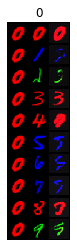

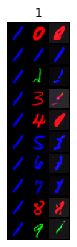

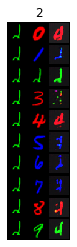

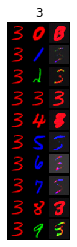

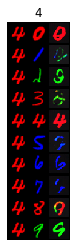

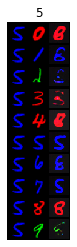

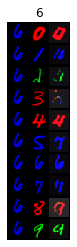

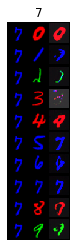

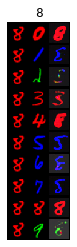

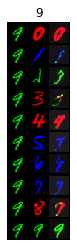

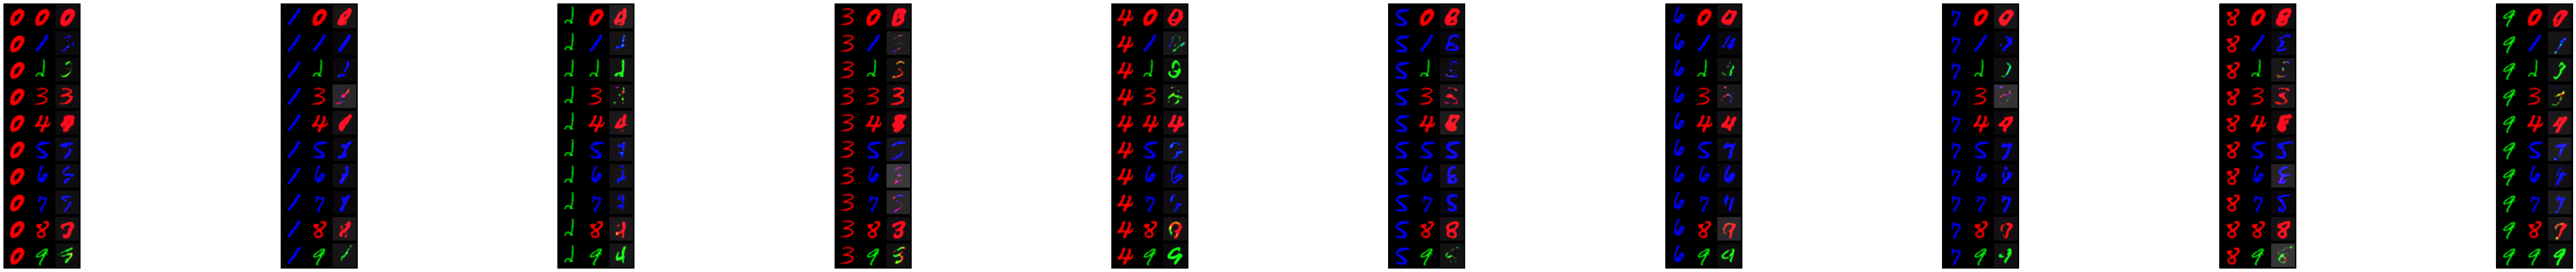

In [24]:
results = save_content_transfers(model,
                      class_reps=class_reps, 
                       log_dir=log_dir, 
                       train_mean=dm.train_mean, 
                       train_std=dm.train_std)
show_timgs(results, nrows=1, factor=10.)


Created:  /data/hayley-old/Tenanbaum2000/lightning_logs/2021-01-14-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1/style_transfers
Created:  /data/hayley-old/Tenanbaum2000/lightning_logs/2021-01-14-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1/style_transfers/version_0


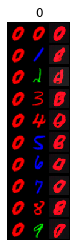

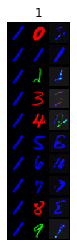

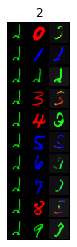

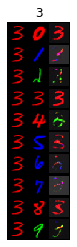

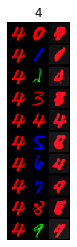

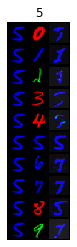

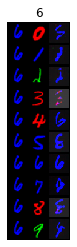

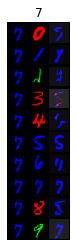

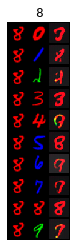

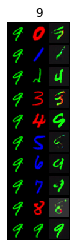

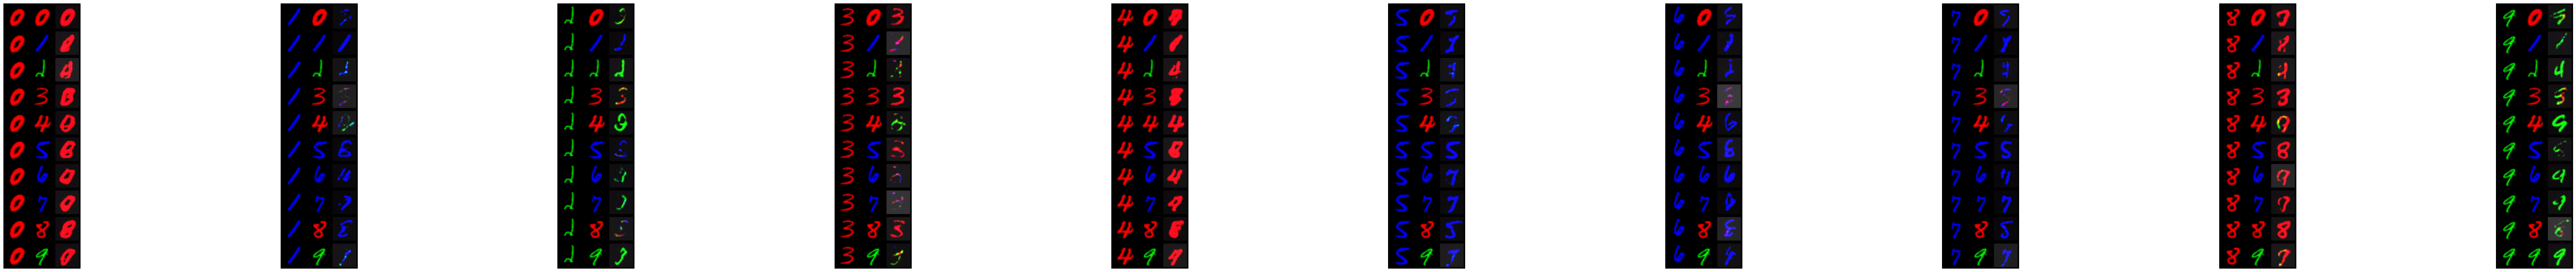

In [25]:
results = save_style_transfers(model,
                      class_reps=class_reps, 
                       log_dir=log_dir, 
                       train_mean=dm.train_mean, 
                       train_std=dm.train_std)
show_timgs(results, nrows=1, factor=10.)


In [ ]:
# run_both_transfers(model,
#                   class_reps=class_reps, 
#                        log_dir=log_dir, 
#                        train_mean=dm.train_mean, 
#                        train_std=dm.train_std)

## Analysis on the latent space
1. Visualize embeddings
    - collect a batch of inputs -> encoder -> [mu, log_var] -> sample -> a batch of z's (embeddings)
    - use tb logger
  
2. Nearest neighbor query


#### Visualize embeddings
- collect a batch of inputs -> encoder -> [mu, log_var] -> sample -> a batch of z's (embeddings)
- use tb logger


In [ ]:
model.eval()
best_global_step = 0#ckpt["global_step"]+1

dl = DataLoader(dm.train_ds, 
                batch_size=128,
               num_workers=16,
               pin_memory=True,
               )


with torch.no_grad():
    for batch in dl:
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']
        label_s = batch['color']
        
        dict_qparams = model.encode(x)
        dict_z = model.rsample(dict_qparams)

    #     z = out['z']

        # log embedding of z_c to tensorboard 
        tb_writer.add_embedding(dict_z['c'],
                             label_img=LinearRescaler()(x), 
                             metadata=label_c.tolist(),
                             global_step=best_global_step, 
                             tag="c"
                            )

        # log embedding of z_s to tensorboard 
        tb_writer.add_embedding(dict_z['s'],
                             label_img=LinearRescaler()(x), 
                             metadata=label_s.tolist(),
                             global_step=best_global_step, 
                             tag="s"
                            )


## Visualize original images of the close neighbors in the latent space
- Compute pairwise distance using cosine similarity
- For each row (ie. a latent code), get the index of the smallest values. 
- Select the images in the batch x and visualize (can do this all in show_timgs)



In [26]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

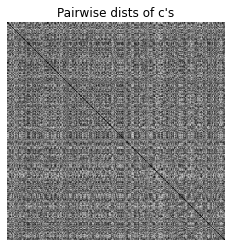

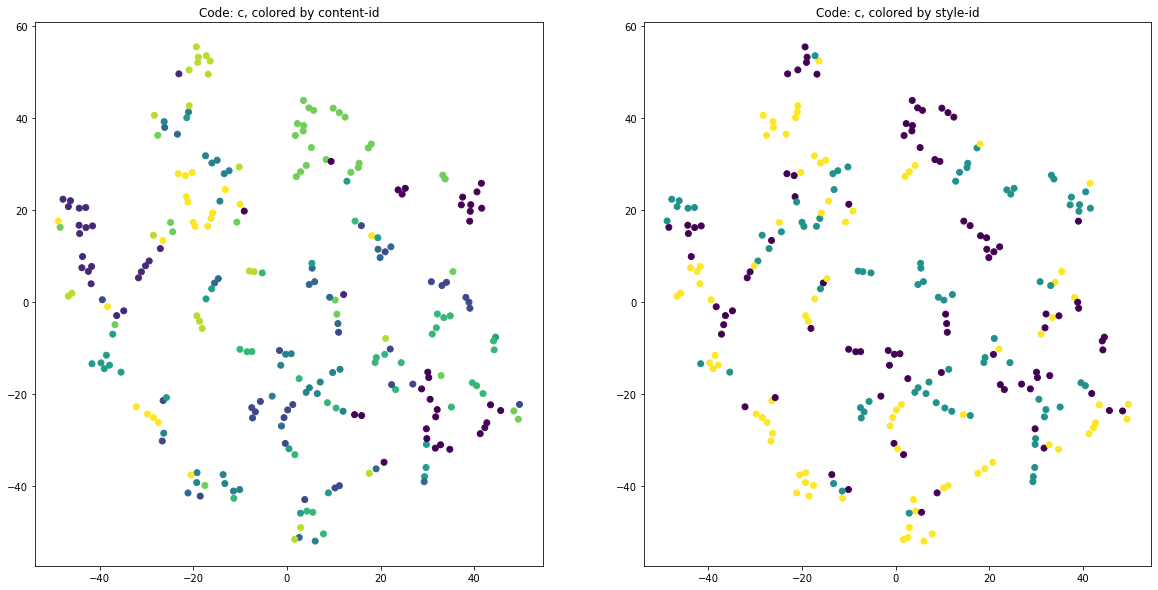

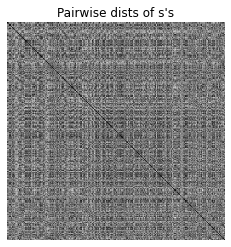

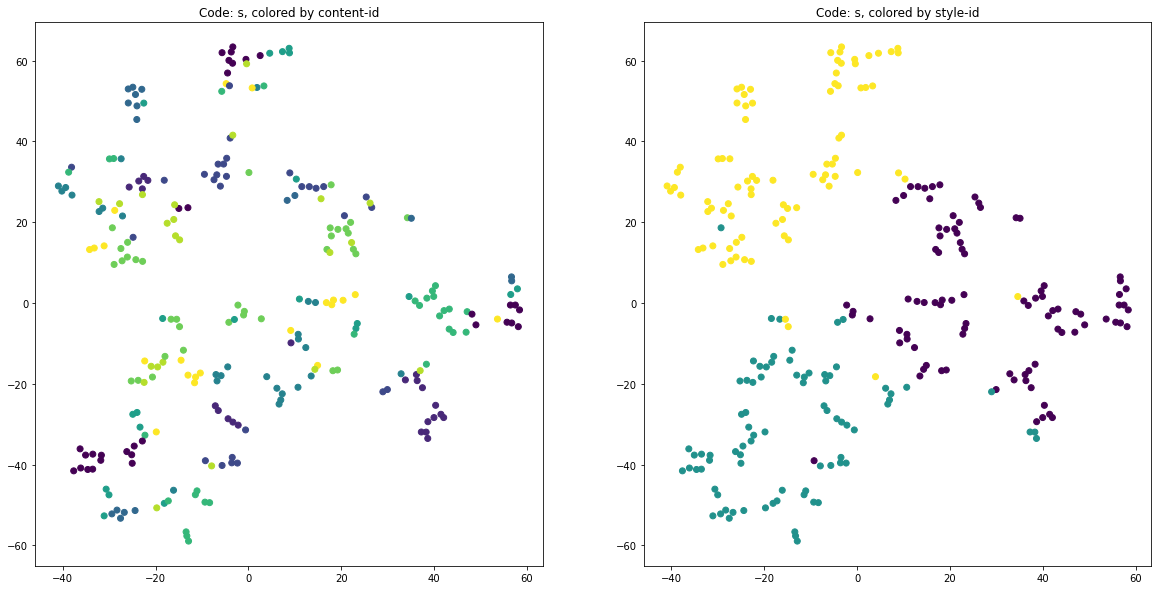

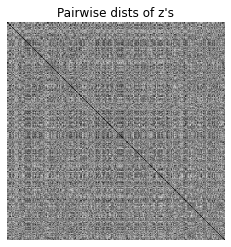

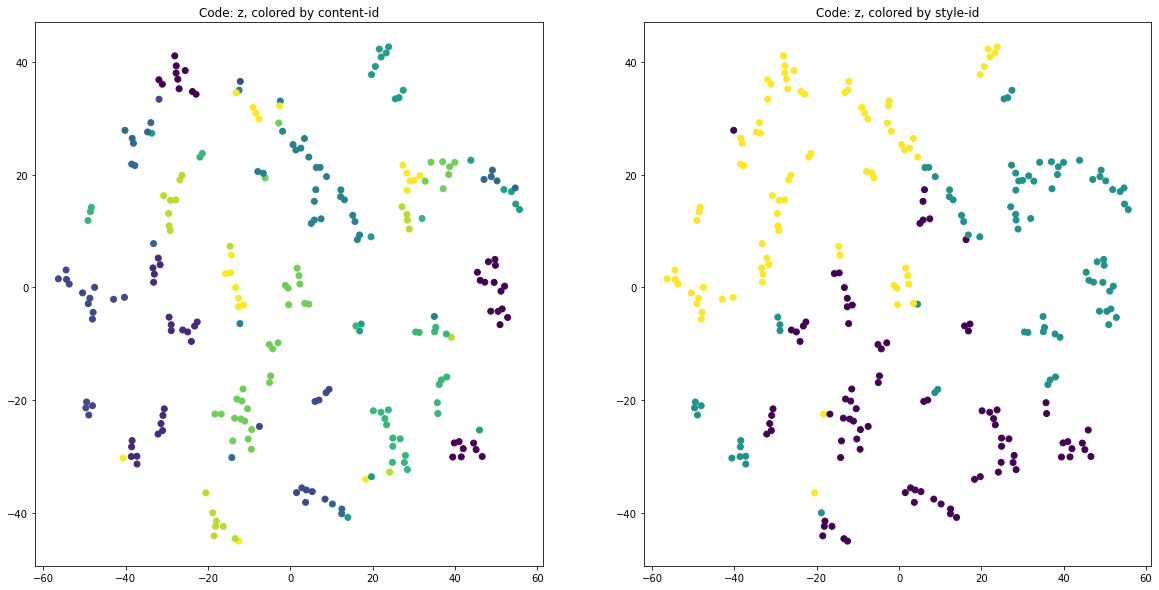

In [29]:
model.eval()
mode = 'train'
query_size = 256 #1024
metric = 'cosine' #pairwise distance metric in content space
ds = getattr(dm, f"{mode}_ds")
dl = DataLoader(ds, batch_size=query_size, shuffle=True)
# tsne params
tsne_dim = 2
tsne_p = 5. #10 #perplexity
# tsne_metric = 'euclidean'
tsne_metric = 'cosine' 
tsne = TSNE(n_components=tsne_dim, metric=tsne_metric, perplexity=tsne_p )
with torch.no_grad():
    batch = next(iter(dl))
    x = batch['img']
    label_c = batch['digit']  # digit/content label (int) -- currently not used
    label_s = batch['color']

    dict_qparams = model.encode(x)
    dict_z = model.rsample(dict_qparams)
    c = dict_z['c']
    s = dict_z['s']
    z = model.combine_content_style(dict_z)

    for name, embedding in zip(["c", "s", "z"], [c,s,z]):
        # Compute pairwise distance of the embeddings
        pdists = pairwise_distances(embedding.numpy(), metric=metric)
        plt.imshow(pdists, cmap='gray')
        plt.title(f"Pairwise dists of {name}'s")
        plt.axis('off')
        plt.show()
        
        # show the 2dim view on the codes
        embedding_2d = tsne.fit_transform(embedding)
        
        f, ax = plt.subplots(1,2, figsize=(20,10))
        # first plot the 2dim embeddings and color-code by content id
        ax[0].scatter(embedding_2d[:,0], embedding_2d[:,1],
                     c = label_c)
        
        ax[0].set_title(f"Code: {name}, colored by content-id")
        
        # same embedding plot, but color-code by style-id
        ax[1].scatter(embedding_2d[:,0], embedding_2d[:,1],
                     c = label_s),
        ax[1].set_title(f"Code: {name}, colored by style-id")
        
        plt.show()
        
#         # Nearest neighbor queries
#         # smaller values means closer in distance
#         n_ngbrs = 10
#         n_rows = min(query_size, 32)

#         selected_rows = np.random.choice(len(x), size=n_rows)
#         for idx in selected_rows:
#             args = np.argsort(pdists[idx])[:n_ngbrs]
#     #         print(args)
#             show_timgs(LinearRescaler()(x[args]), cmap='gray', factor=2, 
#                        nrows=1, title=f'Nearest of digit {y[idx].item()}: {name}')
#             plt.show()

### Distribution of qparams for content/style codes
Given a batch of images with the same content, 
we hypothesize/an ideally leanred model will put their content codes in a close neighborhood in the content latent space. Then, the average of a batch of mu_qc's will be a vector that indicates the center/mean of the mu_qc of each image (whose content-id is the same across the input batch).

- Show the histogram of each dimension's mu_qc_j across the batch: one histogram for each dimension j
- Compute the average mu_qc over the batch of mu_qc's. Then, use it as the input content code with some input image's style code to the generator. What is the generated output? Does its content look something like the content of the batch of image?


In [ ]:
mu_xlim = (-4., 4.)
# var_xlim = (0, 0.05)
n_samples = 1024
# Set output dir
out_dir = log_dir/"dist_qparams_per_content"
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created and saving to: ", out_dir)
    
for digit_id in range(10):
    # Collect a batch of images of the same content
    xs = []
    n_collected = 0
    while n_collected <= n_samples:
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']
        label_s = batch['color']
        selected = x[label_c==digit_id]
        xs.append(selected)
        n_collected += len(selected)
    xs = torch.cat(xs, dim=0)
    print(f" Digit {digit_id} collected. Input: {xs.shape}")


    # Plot the distributions of qc parameters and qs parameters
    model.eval()
    with torch.no_grad():
        dict_qparams = model(xs)

        # Dist. of each content dim's parameters
        mu_qc, var_qc = dict_qparams['mu_qc'], dict_qparams['logvar_qc'].exp() #(BS, content_dim), (BS, style_dim)
        # -- mu_qc's
#         mu_xlim = (0, max(mu_qc)
        f, ax = plt.subplots(1, model.content_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $mu^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(mu_qc[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-mu_qc.png")
        plt.show()
        
        # -- var_qc's
        var_xlim = (0, var_qc.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $var^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(var_qc[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-var_qc.png")
        plt.show()

        
        # Dist. of each style dim's parameters
        mu_qs, var_qs = dict_qparams['mu_qs'], dict_qparams['logvar_qs'].exp()
        # -- mu_qs's
#         mu_xlim = (0, max(mu_qs))
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $mu^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(mu_qs[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-mu_qs.png")
        plt.show()
        
        # -- var_qs's
        var_xlim = (0, var_qs.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Digit {digit_id}: " + r"Dist. of $var^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(var_qs[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"digit-{digit_id}-var_qs.png")
        plt.show()

Created and saving to:  /data/hayley-old/Tenanbaum2000/lightning_logs/2021-01-14-ray/BiVAE-C_MNIST-red-green-blue_seed-123/version_1/dist_qparams_per_content
 Digit 0 collected. Input: torch.Size([1036, 3, 32, 32])


- Collect a batch of images with the same style: one such batch for style.
Then plot the histogram of mu_qs_j over the batch: one histogram for a dimension of a style code.

In [ ]:
mu_xlim = (-4., 4.)
n_styles = dm.n_styles
# var_xlim = (0, 0.05)
n_samples = 1024
# Set output dir
out_dir = log_dir/"dist_qparams_per_style"
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print("Created and saving to: ", out_dir)
    
for style_id in range(n_styles):
    # Collect a batch of images of the same content
    xs = []
    n_collected = 0
    while n_collected <= n_samples:
        batch = next(iter(dl))
        x = batch['img']
        label_c = batch['digit']
        label_s = batch['color']
        selected = x[label_c==style_id]
        xs.append(selected)
        n_collected += len(selected)
    xs = torch.cat(xs, dim=0)
    print(f"Style {style_id} collected. Input: {xs.shape}")


    # Plot the distributions of qc parameters and qs parameters
    model.eval()
    with torch.no_grad():
        dict_qparams = model(xs)

        # Dist. of each content dim's parameters
        mu_qc, var_qc = dict_qparams['mu_qc'], dict_qparams['logvar_qc'].exp() #(BS, content_dim), (BS, style_dim)
        # -- mu_qc's
#         mu_xlim = (0, max(mu_qc)
        f, ax = plt.subplots(1, model.content_dim, figsize=(20,2))
        title = f"Style {style_id}: " + r"Dist. of $mu^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(mu_qc[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{style_id}-mu_qc.png")
        plt.show()
        
        # -- var_qc's
        var_xlim = (0, var_qc.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Style {stlye_id}: " + r"Dist. of $var^{c}_j$"
        f.suptitle(title)
        for j in range(model.content_dim):
            ax[j].hist(var_qc[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{stlye_id}-var_qc.png")
        plt.show()

        
        # Dist. of each style dim's parameters
        mu_qs, var_qs = dict_qparams['mu_qs'], dict_qparams['logvar_qs'].exp()
        # -- mu_qs's
#         mu_xlim = (0, max(mu_qs))
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Style {stlye_id}: " + r"Dist. of $mu^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(mu_qs[:,j])
            ax[j].set_xlim(mu_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{stlye_id}-mu_qs.png")
        plt.show()
        
        # -- var_qs's
        var_xlim = (0, var_qs.max().item())
        f, ax = plt.subplots(1, model.style_dim, figsize=(20,2))
        title = f"Style {stlye_id}: " + r"Dist. of $var^{s}_j$"
        f.suptitle(title)
        for j in range(model.style_dim):
            ax[j].hist(var_qs[:,j])
            ax[j].set_xlim(var_xlim)
            ax[j].set_title(f"dim {j}")
        f.tight_layout()
        f.savefig(out_dir/f"Style-{stlye_id}-var_qs.png")
        plt.show()

## Latent Space Traversal
1. Linear traversal in a single dimension

In [ ]:
chosen_dim = 0 # must be in range(latent_dim)
fixed_vec = torch.randn((1, model.latent_dim-1))
fixed_values = fixed_vec.repeat((n_samples,1))
n_samples = 16
zi_min, zi_max = -2,2
varying = torch.linspace(zi_min, zi_max, n_samples).view((-1,1))

varying.shape,fixed_values.shape





In [ ]:
def construct_from(a_col:torch.Tensor, other_cols:torch.Tensor, ind):
    """
    Make a tensor from a column vector and a matrx containing all the other columns
    by inserting the `onc_column` at the final matrix's `ind`th column.
    """
    assert a_
    n_cols = 1 + 
    out = a_col.new_zeros((